# (04) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

## Omniglot, MLP decoder

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('Omniglot', model_type, 'jacob|mlp')

seq_len = 32

cfg_vae['track_stats'] = True
cfg_vae['n_latents'] = 256
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 2/4 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  718.6 K   |
|     ———     |    ———     |
|    layer    |  718.6 K   |
+-------------+------------+

poisson_Omniglot_t-32_z-[256]_<jacob|mlp>
b200-ep1500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,22:34)

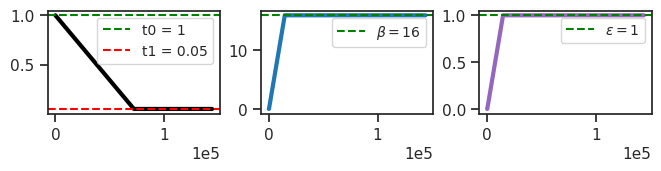

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

144000

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  718.6 K   |
|     ———      |    ———     |
|     dec      |  718.1 K   |
+--------------+------------+

In [8]:
tr.alphas, tr.alphas_time

(None, None)

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 32, 'n_latents': [256], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'Omniglot', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_Omniglot_t-32_z-[256]_<jacob|mlp>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_Omniglot_t-32_z-[256]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 1500, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 498.3333333333333, 'eta_min': 1e-05}, 'ema_rate': None, 
'grad_clip': 50, 'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 16.0, 'kl_beta_min':
0.0001, 'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 
'kl_const_portion': 0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 
0.05}

### Fit model

In [10]:
tr.train()

epoch # 1500, avg loss: 16.969598: 100%|██| 1500/1500 [9:11:55<00:00, 22.08s/it]


**Task:** Omniglot, $(T, \beta) = (32, 16.0)$, MLP decoder, z-256

-Done: Omniglot, $(T, \beta) = (32, 16.0)$, MLP decoder, z-128

In [11]:
print(tr.model.layer.n_exp)

tensor([17, 18, 19, 22, 27, 32, 36, 38, 41, 44, 46, 48, 50, 51, 53, 54, 55, 56,
        57, 58, 59, 59, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61],
       device='cuda:1', dtype=torch.int32)

In [12]:
## Was: linear decoder

tensor([12, 14, 16, 19, 22, 25, 28, 31, 35, 38, 41, 43, 45, 46, 47, 48, 48, 49,
        50, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51],
       device='cuda:1', dtype=torch.int32)

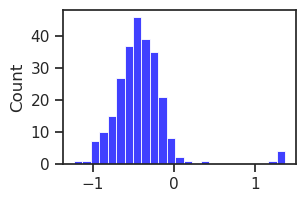

In [12]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

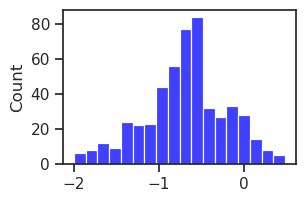

In [13]:
## Was: linear decoder

In [13]:
dead = log_rate > 1
dead.sum()

5

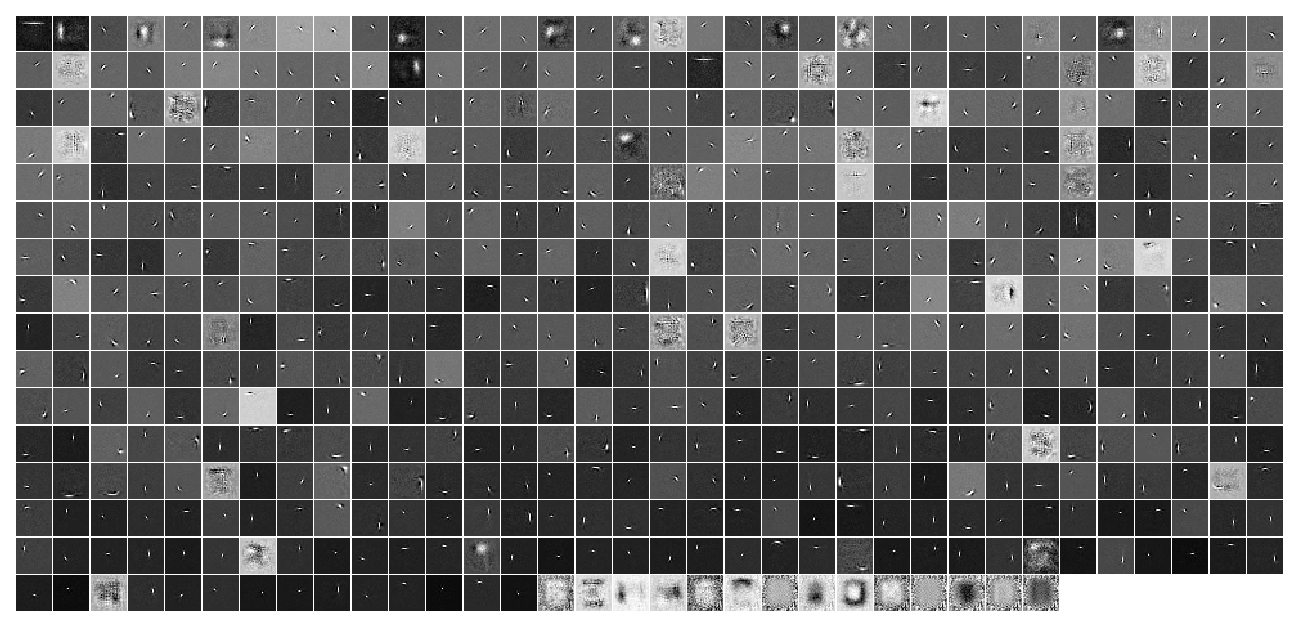

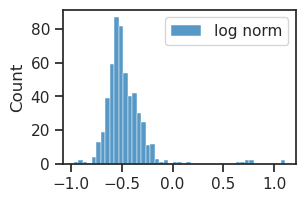

In [14]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

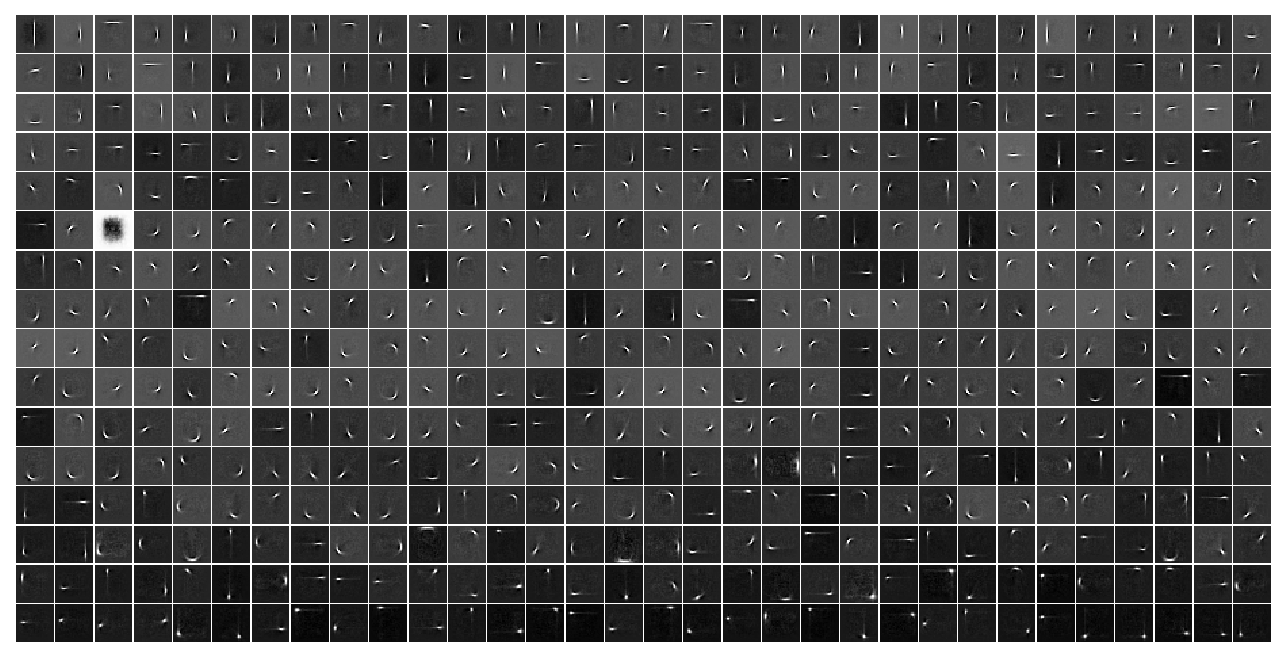

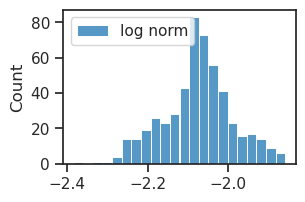

In [14]:
## Was: linear decoder

100%|█████████████████████████████████| 66/66 [35:27<00:00, 32.24s/it]


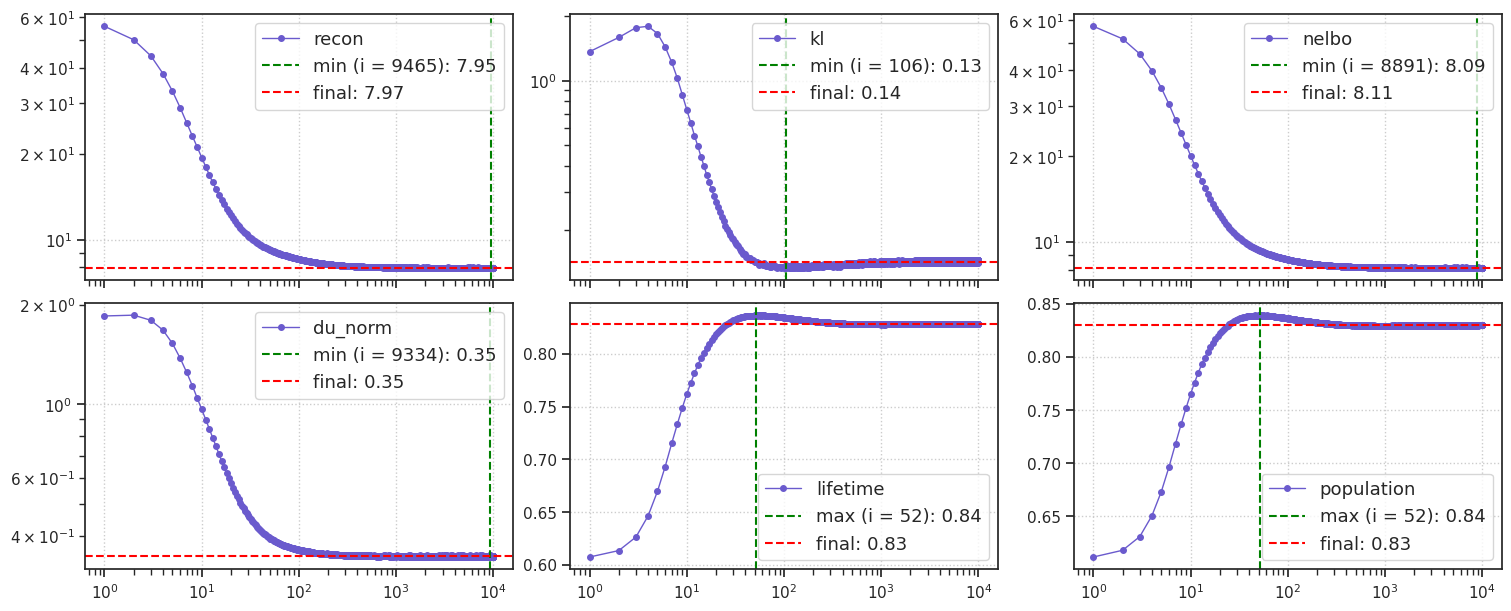

CPU times: user 34min 35s, sys: 1min 19s, total: 35min 55s
Wall time: 36min 8s


In [21]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='slateblue')

100%|█████████████████████████████████| 66/66 [04:50<00:00,  4.40s/it]


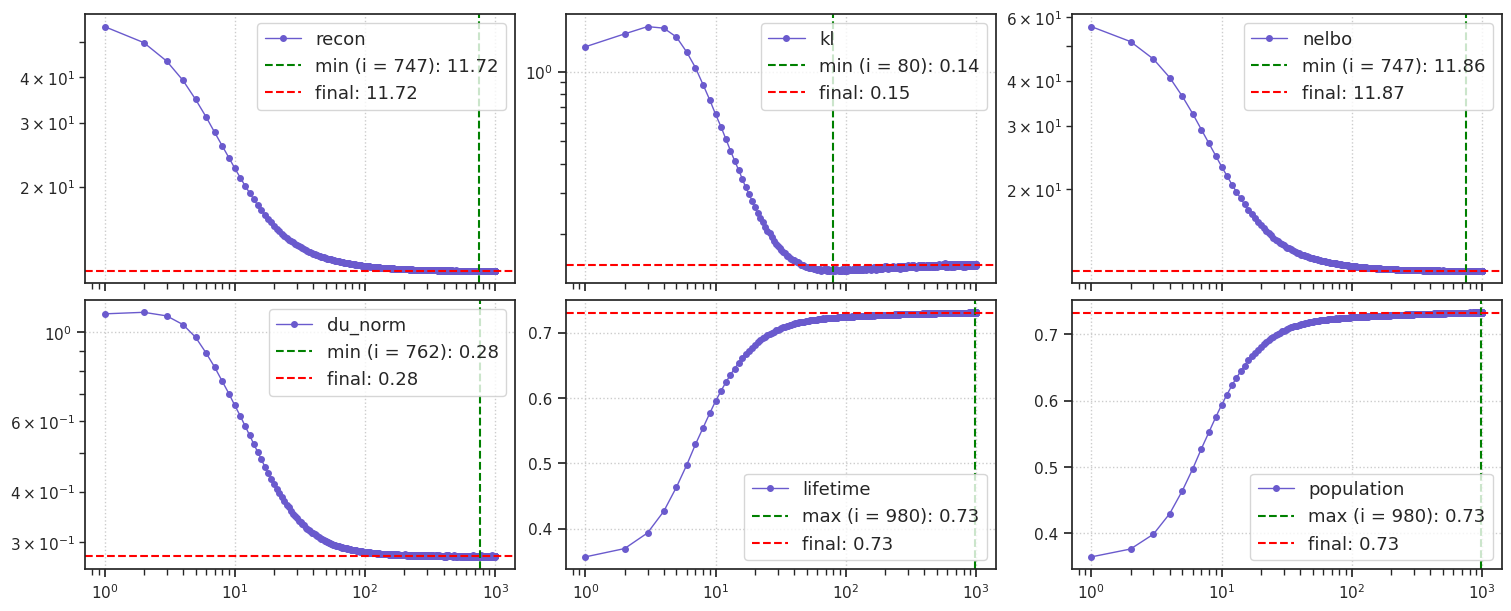

CPU times: user 4min 48s, sys: 4.21 s, total: 4min 52s
Wall time: 4min 54s


In [15]:
## Was: (T, beta) = (32, 16.0), MLP decoder, z-128

100%|█████████████████████████████████| 66/66 [04:01<00:00,  3.65s/it]


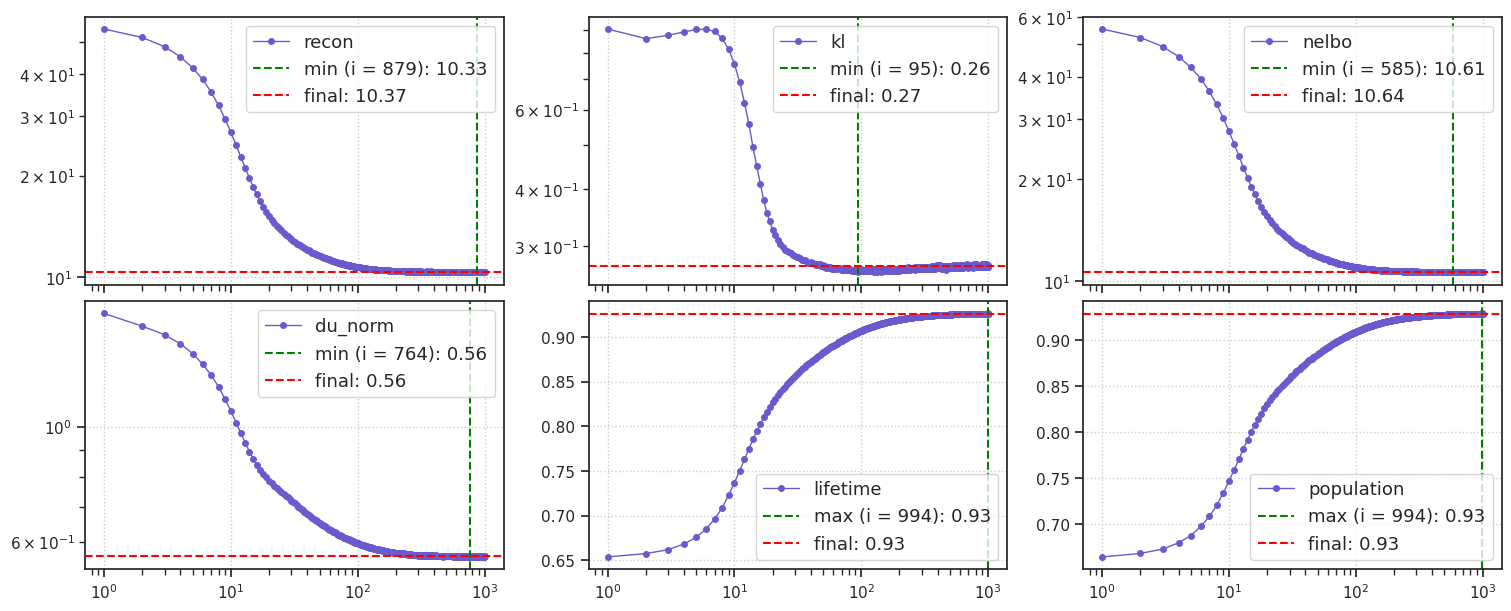

CPU times: user 3min 57s, sys: 13.1 s, total: 4min 10s
Wall time: 4min 10s


In [16]:
# Was: linear decoder

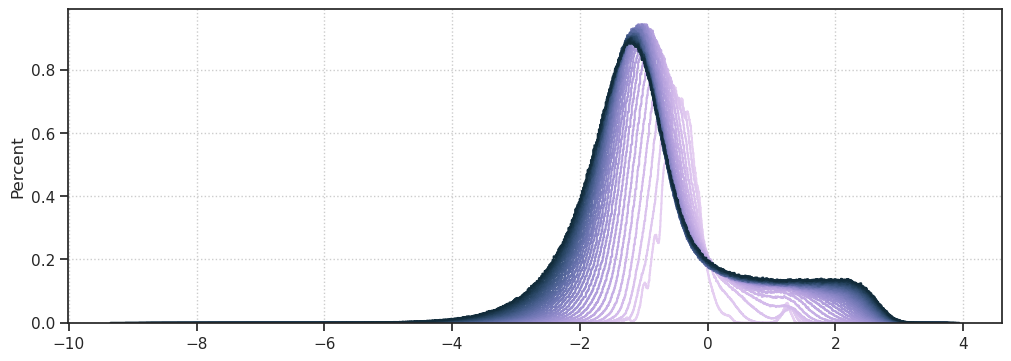

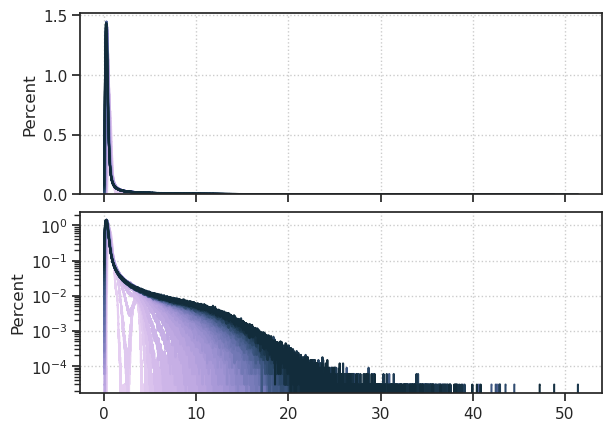

In [18]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v.ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [20]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.7772434076485234, 0.6867201851051512, 0.8992465126713316],
 [0.7488140989847138, 0.663555547374397, 0.8871239594805421],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.6942872011488744, 0.6228296550346212, 0.8621156899688018],
 [0.6634569388588049, 0.6014800804909103, 0.8468058114666168],
 [0.6320229476966513, 0.5806736799351144, 0.8302290653034528],
 [0.6054622546457821, 0.5637088831281258, 0.8154071610911845],
 [0.5732669768785542, 0.5437477179008751, 0.796373094555329],
 [0.5408481910037145, 0.5241596982434596, 0.7759471682023664],
 [0.5083422913995962, 0.504879311294484, 0.7541087857318404],
 [0.4758855120154583, 0.4858388067481777, 0.730849789285715],
 [0.4489733517135627, 0.47010481056940817, 0.7103848289900052],
 [0.41695667742563003, 0.45132234628574797, 0.6845415010609894],
 [0.3853671819459071, 0.4325792609108464, 0.6573219220304894],
 [0.3543330369823173, 0.41380307712511316, 0.628765276150995],
 [0.32397841491559515, 0.39492111612543246, 0.5989227356460889],
 [0.29928829086417397, 0.37905306216481705, 0.573116704238121],
 [0.27048567879155966, 0.3597894788979849, 0.5410882946355793],
 [0.24268617428117248, 0.34021688339911954, 0.5079815698469353],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.19465923277609198, 0.3033020135929155, 0.4448050493246117],
 [0.17023092176723864, 0.2824832211946367, 0.4091883255554043],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

In [19]:
def fit_norm(data):
    rv = sp_stats.norm(*sp_stats.norm.fit(data))
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='norm',
        args=(rv.mean(), rv.std()),
    )
    return rv, ks_test


def fit_t(data):
    df, loc, scale = sp_stats.t.fit(data)
    rv = sp_stats.t(df, loc, scale)
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='t',
        args=(df, loc, scale),
    )
    return rv, ks_test

In [ ]:
nrows = 4
ncols = int(np.ceil(len(posterior_log_rates) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all')
for t, data in tqdm(posterior_log_rates.items()):
    rv, ks_test = fit_norm(data[:, ~dead].ravel())
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    i = int(t)
    ax = axes.flat[i]
    sns.histplot(data.ravel(), stat='density', color=pal[i], label=f"t = {t}", ax=ax)
    ax.plot(xs, pdf, color='r')
    ax.set(title=f"p = {ks_test.pvalue:0.2g}", ylabel='')
add_legend(axes)
plt.show()

In [ ]:
nrows = 4
ncols = int(np.ceil(len(posterior_log_rates) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all')
for t, data in tqdm(posterior_log_rates.items()):
    rv, ks_test = fit_t(data[:, ~dead].ravel())
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    i = int(t)
    ax = axes.flat[i]
    sns.histplot(data.ravel(), stat='density', color=pal[i], label=f"t = {t}", ax=ax)
    ax.plot(xs, pdf, color='r')
    ax.set(title=f"p = {ks_test.pvalue:0.2g}", ylabel='')
add_legend(axes)
plt.show()

## Omniglot, linear decoder

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('Omniglot', model_type, 'jacob|lin')

seq_len = 32

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 2/4 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  402.4 K   |
|     ———     |    ———     |
|    layer    |  402.4 K   |
+-------------+------------+

poisson_Omniglot_t-32_z-[512]_<jacob|lin>
b200-ep1000-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,11:28)

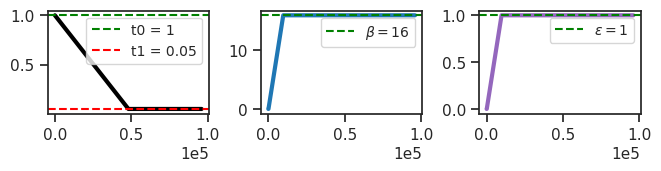

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

96000

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  402.4 K   |
|     ———      |    ———     |
|    fc_dec    |  401.4 K   |
+--------------+------------+

In [8]:
tr.alphas, tr.alphas_time

(None, None)

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -4, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 32, 'n_latents': [512], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'lin', 'dataset': 
'Omniglot', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_Omniglot_t-32_z-[512]_<jacob|lin>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_Omniglot_t-32_z-[512]_<jacob|lin>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 1000, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 331.6666666666667, 'eta_min': 1e-05}, 'ema_rate': None, 
'grad_clip': 50, 'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 16.0, 'kl_beta_min':
0.0001, 'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 
'kl_const_portion': 0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 
0.05}

### Fit model

In [10]:
tr.train()

epoch # 1000, avg loss: 22.122722: 100%|██| 1000/1000 [2:14:14<00:00,  8.05s/it]


**Task:** fitting Omniglot, $(T, \beta) = (32, 16.0)$, linear decoder

In [12]:
print(tr.model.layer.n_exp)

tensor([12, 14, 16, 19, 22, 25, 28, 31, 35, 38, 41, 43, 45, 46, 47, 48, 48, 49,
        50, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51],
       device='cuda:1', dtype=torch.int32)

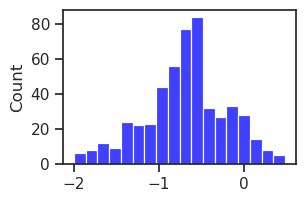

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

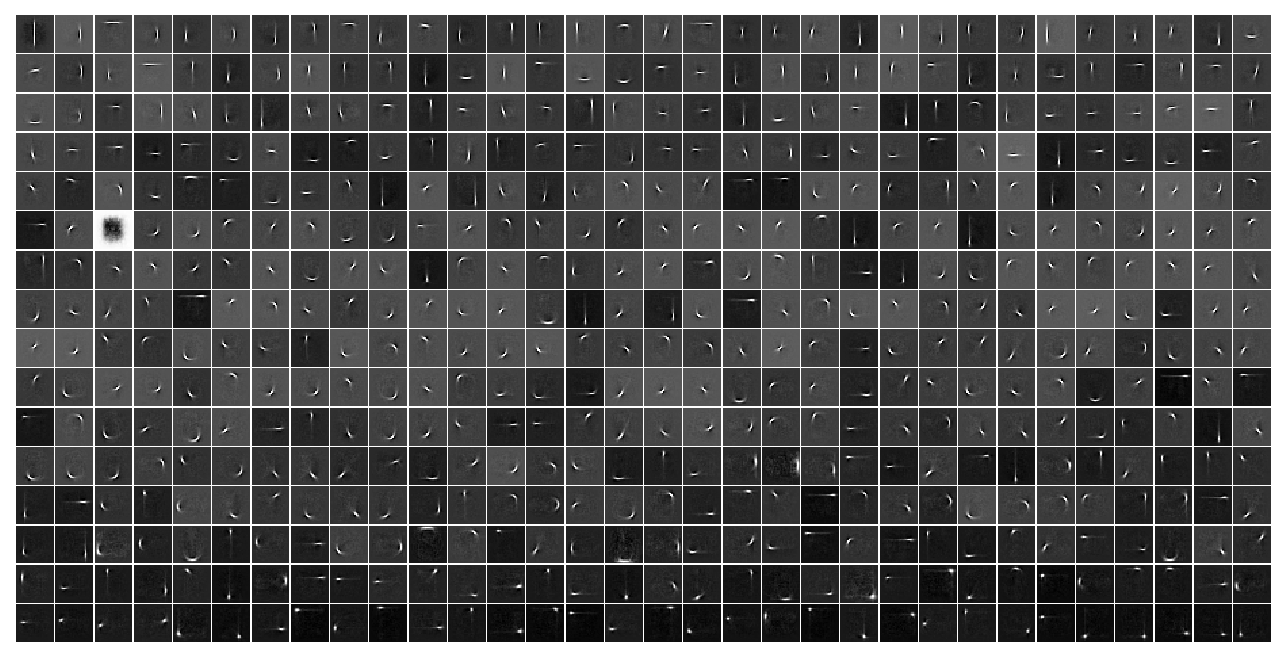

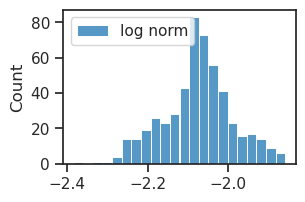

In [14]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

In [15]:
dead = log_rate > 1
dead.sum()

0

100%|█████████████████████████████████| 66/66 [04:01<00:00,  3.65s/it]


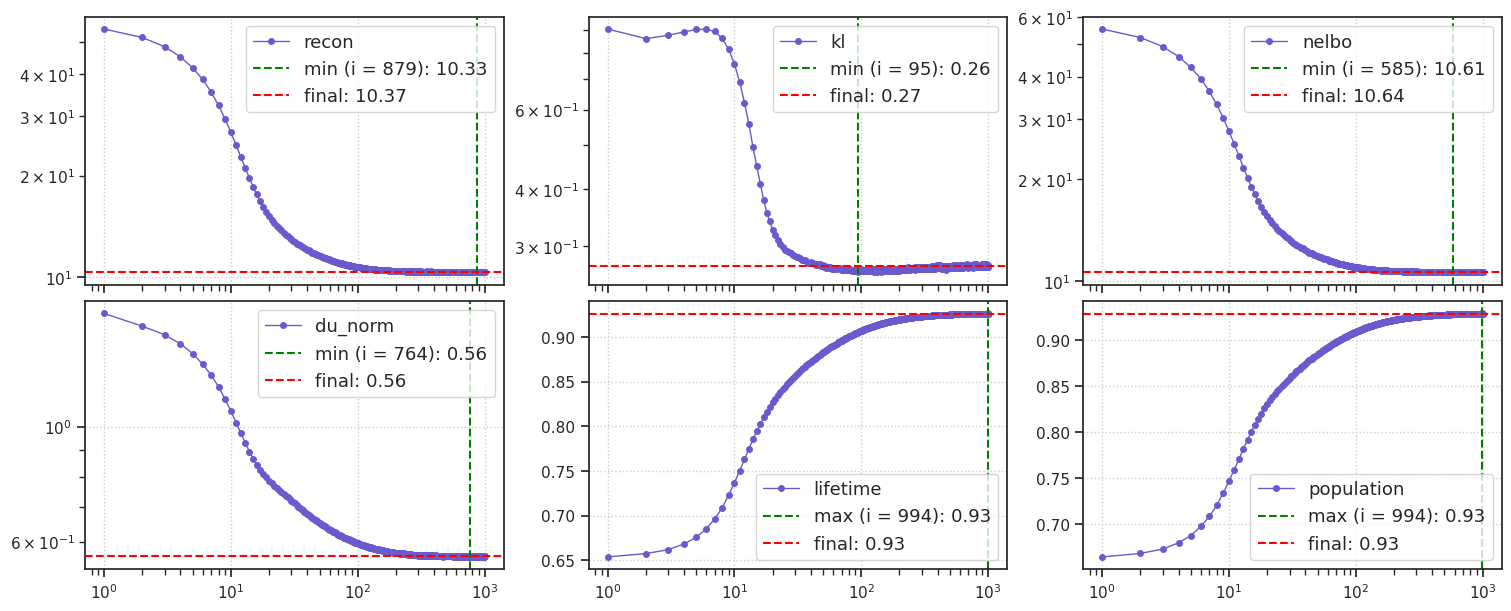

CPU times: user 3min 57s, sys: 13.1 s, total: 4min 10s
Wall time: 4min 10s


In [16]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='slateblue')

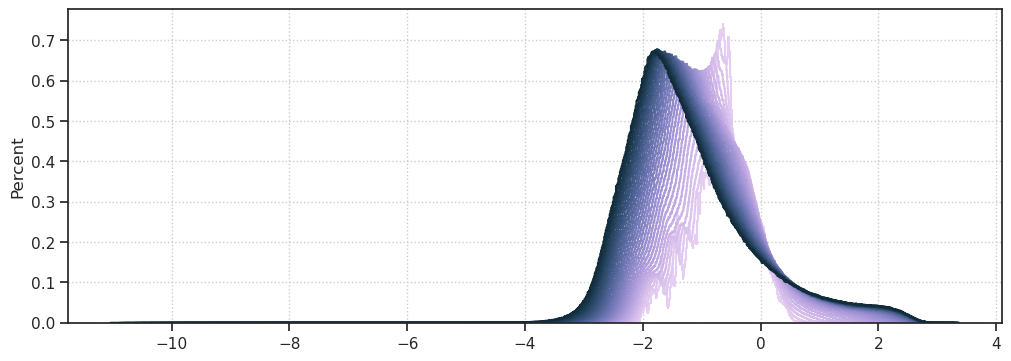

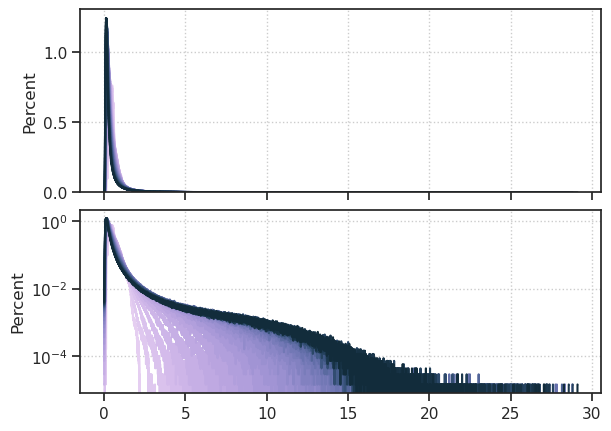

In [17]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v.ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [18]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.7772434076485234, 0.6867201851051512, 0.8992465126713316],
 [0.7488140989847138, 0.663555547374397, 0.8871239594805421],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.6942872011488744, 0.6228296550346212, 0.8621156899688018],
 [0.6634569388588049, 0.6014800804909103, 0.8468058114666168],
 [0.6320229476966513, 0.5806736799351144, 0.8302290653034528],
 [0.6054622546457821, 0.5637088831281258, 0.8154071610911845],
 [0.5732669768785542, 0.5437477179008751, 0.796373094555329],
 [0.5408481910037145, 0.5241596982434596, 0.7759471682023664],
 [0.5083422913995962, 0.504879311294484, 0.7541087857318404],
 [0.4758855120154583, 0.4858388067481777, 0.730849789285715],
 [0.4489733517135627, 0.47010481056940817, 0.7103848289900052],
 [0.41695667742563003, 0.45132234628574797, 0.6845415010609894],
 [0.3853671819459071, 0.4325792609108464, 0.6573219220304894],
 [0.3543330369823173, 0.41380307712511316, 0.628765276150995],
 [0.32397841491559515, 0.39492111612543246, 0.5989227356460889],
 [0.29928829086417397, 0.37905306216481705, 0.573116704238121],
 [0.27048567879155966, 0.3597894788979849, 0.5410882946355793],
 [0.24268617428117248, 0.34021688339911954, 0.5079815698469353],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.19465923277609198, 0.3033020135929155, 0.4448050493246117],
 [0.17023092176723864, 0.2824832211946367, 0.4091883255554043],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

## vH16

$T = 8, \quad \beta = 4.0, \quad$  init_scale = 1e-4

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jacob|lin')

cfg_vae['track_stats'] = True
cfg_tr['kl_beta'] = 4

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  132.1 K   |
|     ———     |    ———     |
|    layer    |  132.1 K   |
+-------------+------------+

poisson_vH16_t-8_z-[512]_<jacob|lin>
b200-ep300-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,20:27)

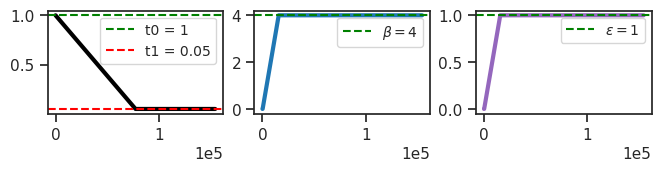

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

154500

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

In [8]:
tr.alphas, tr.alphas_time

(None, None)

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -4, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 8, 'n_latents': [512], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'lin', 'dataset': 
'vH16', 'input_sz': (1, 16, 16), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.0001, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_vH16_t-8_z-[512]_<jacob|lin>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_vH16_t-8_z-[512]_<jacob|lin>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 300, 'batch_size': 200, 'file_name': None, 'warm_restart': 0, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 295.0, 'eta_min': 1e-05}, 'ema_rate': None, 'grad_clip': 
500, 'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'use_amp': False, 'method': 'mc', 'kl_beta': 4, 
'kl_beta_min': 0.0001, 'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 
0.1, 'kl_const_portion': 0.001, 'lambda_anneal': False, 'lambda_init': 0.0, 'lambda_norm': 0.0, 
'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

### Fit model

In [10]:
tr.train(f"u:({tr.model.cfg.clamp_u})-du:({tr.model.cfg.clamp_du})_{tr.cfg.name()}")

epoch # 300, avg loss: 92.976083: 100%|█████| 300/300 [1:36:21<00:00, 19.27s/it]


**Task:** testing the effect of smaller init_scale on:

$T = 8,\quad\beta = 4.0$

In [12]:
print(tr.model.layer.n_exp)

tensor([32, 60, 87, 94, 94, 94, 93, 94], device='cuda:1', dtype=torch.int32)

In [10]:
## Was: T = 8, beta = 8.0

tensor([21, 40, 65, 79, 83, 83, 82, 82], device='cuda:1', dtype=torch.int32)

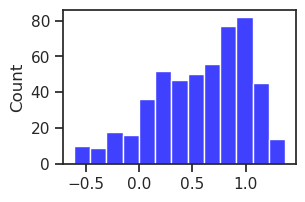

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

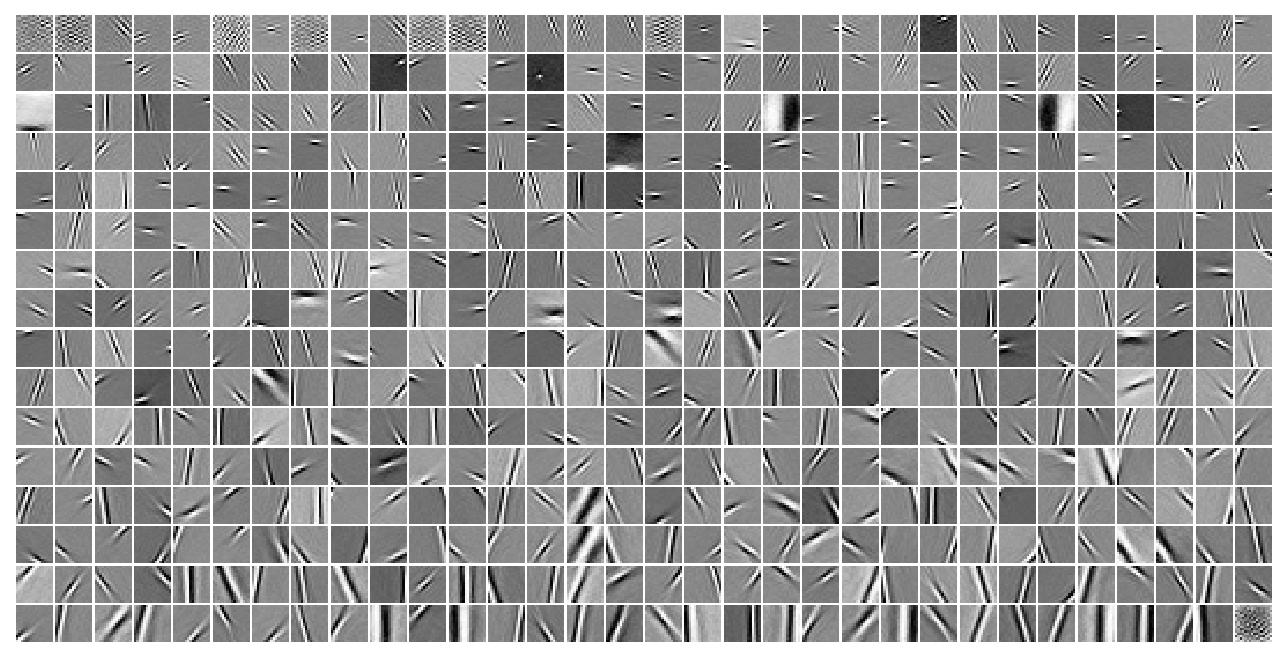

In [14]:
tr.model.show(order=np.argsort(log_rate));

In [15]:
dead = log_rate < -3
dead.sum()

0

100%|███████████████████████████████| 130/130 [08:46<00:00,  4.05s/it]


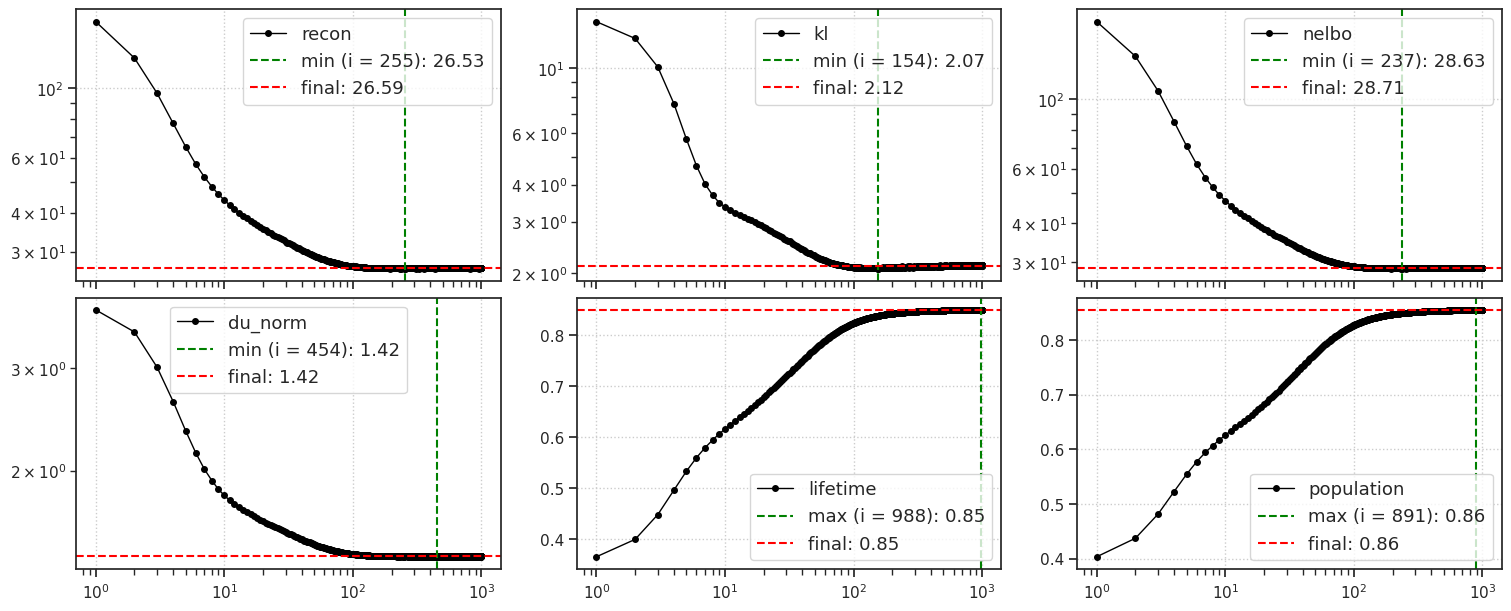

CPU times: user 8min 35s, sys: 26.1 s, total: 9min 1s
Wall time: 9min 1s


In [16]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='k')

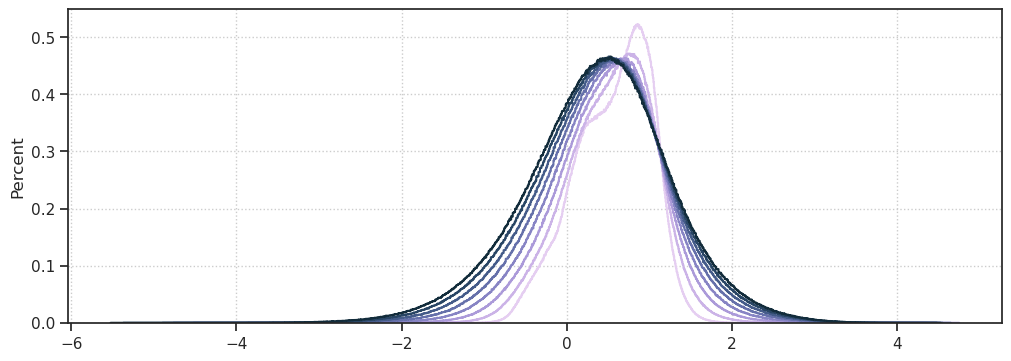

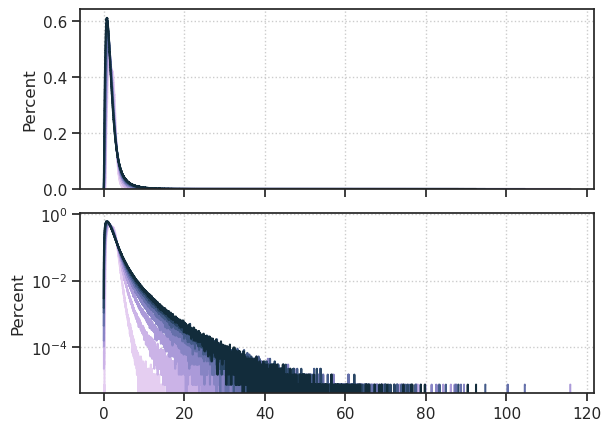

In [17]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v.ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [18]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.79560472689218, 0.7025635211553574, 0.906794768375293],
 [0.6686407796183966, 0.6049991340541501, 0.8494437689559234],
 [0.5300158317387482, 0.5177020247219766, 0.7688253061707515],
 [0.3958415626832449, 0.4388270462167934, 0.6665458619228831],
 [0.26577992459661565, 0.3565507347057864, 0.5356429755155622],
 [0.158519102797742, 0.271866265196377, 0.39112323360373646],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

In [19]:
def fit_norm(data):
    rv = sp_stats.norm(*sp_stats.norm.fit(data))
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='norm',
        args=(rv.mean(), rv.std()),
    )
    return rv, ks_test

100%|█████████████████████████████████████████████| 8/8 [00:54<00:00,  6.78s/it]


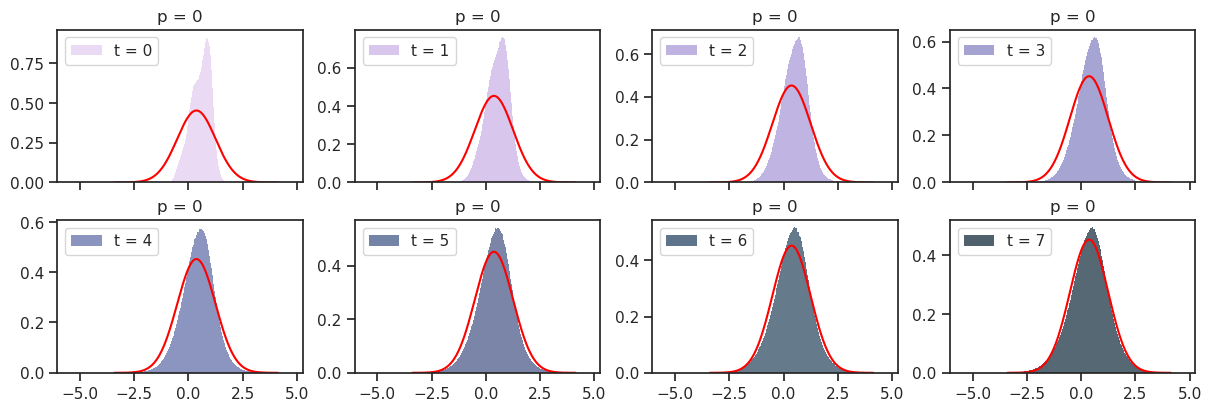

In [41]:
nrows = 2
ncols = int(np.ceil(len(posterior_log_rates) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all')
for t, data in tqdm(posterior_log_rates.items()):
    rv, ks_test = fit_norm(data[:, ~dead].ravel())
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    i = int(t)
    ax = axes.flat[i]
    sns.histplot(data.ravel(), stat='density', color=pal[i], label=f"t = {t}", ax=ax)
    ax.plot(xs, pdf, color='r')
    ax.set(title=f"p = {ks_test.pvalue:0.2g}", ylabel='')
add_legend(axes)
plt.show()

## vH16

$T = 8, \quad \beta = 8.0, $

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jacob|lin')

cfg_vae['track_stats'] = True
cfg_tr['kl_beta'] = 8.0

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  132.1 K   |
|     ———     |    ———     |
|    layer    |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-8_z-[512]_<jacob|lin>
b200-ep300-lr(0.002)_beta(8:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,12:55)

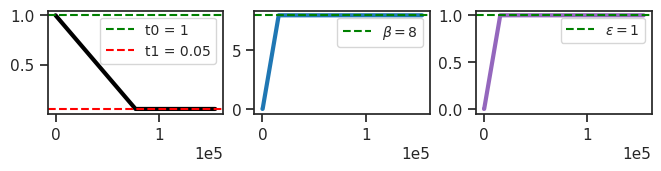

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

154500

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

In [8]:
tr.alphas, tr.alphas_time

(None, None)

### Fit model

In [9]:
tr.train(f"u:({tr.model.cfg.clamp_u})-du:({tr.model.cfg.clamp_du})_{tr.cfg.name()}")

epoch # 300, avg loss: 99.951641: 100%|█████| 300/300 [1:44:01<00:00, 20.80s/it]


Task: compare to below. It was ```clamp_du = 10.0```, now we're doing ```7.0```

In [10]:
print(tr.model.layer.n_exp)

tensor([21, 40, 65, 79, 83, 83, 82, 82], device='cuda:1', dtype=torch.int32)

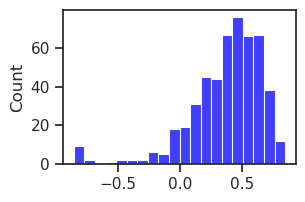

In [11]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

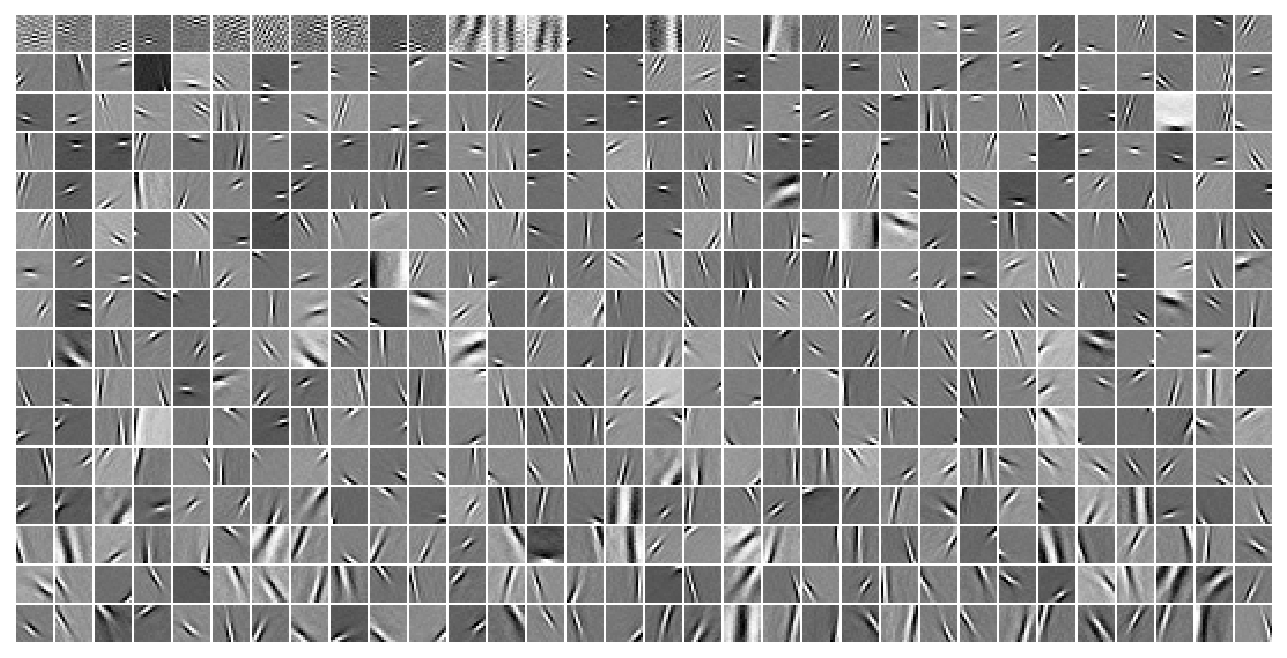

In [16]:
tr.model.show(order=np.argsort(log_rate));

In [17]:
dead = log_rate < -0.6
dead.sum()

11

100%|███████████████████████████████| 130/130 [08:41<00:00,  4.01s/it]


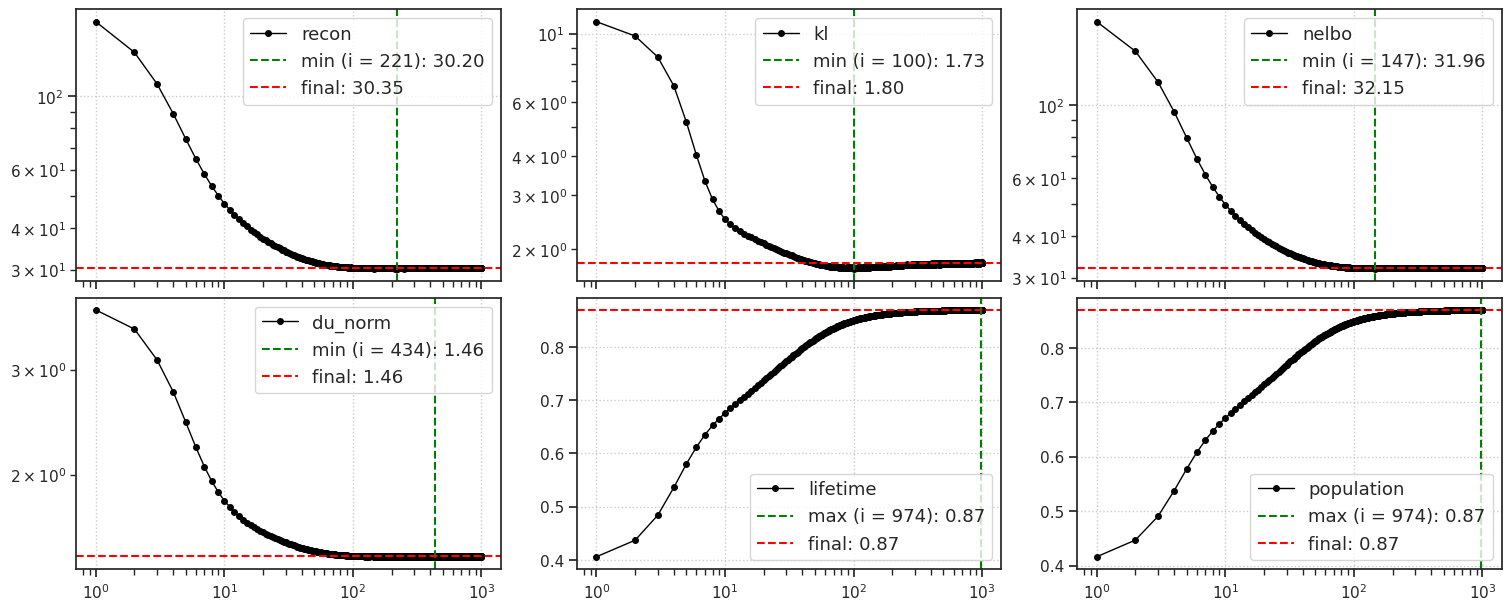

CPU times: user 8min 31s, sys: 25.8 s, total: 8min 56s
Wall time: 8min 56s


In [19]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='k')

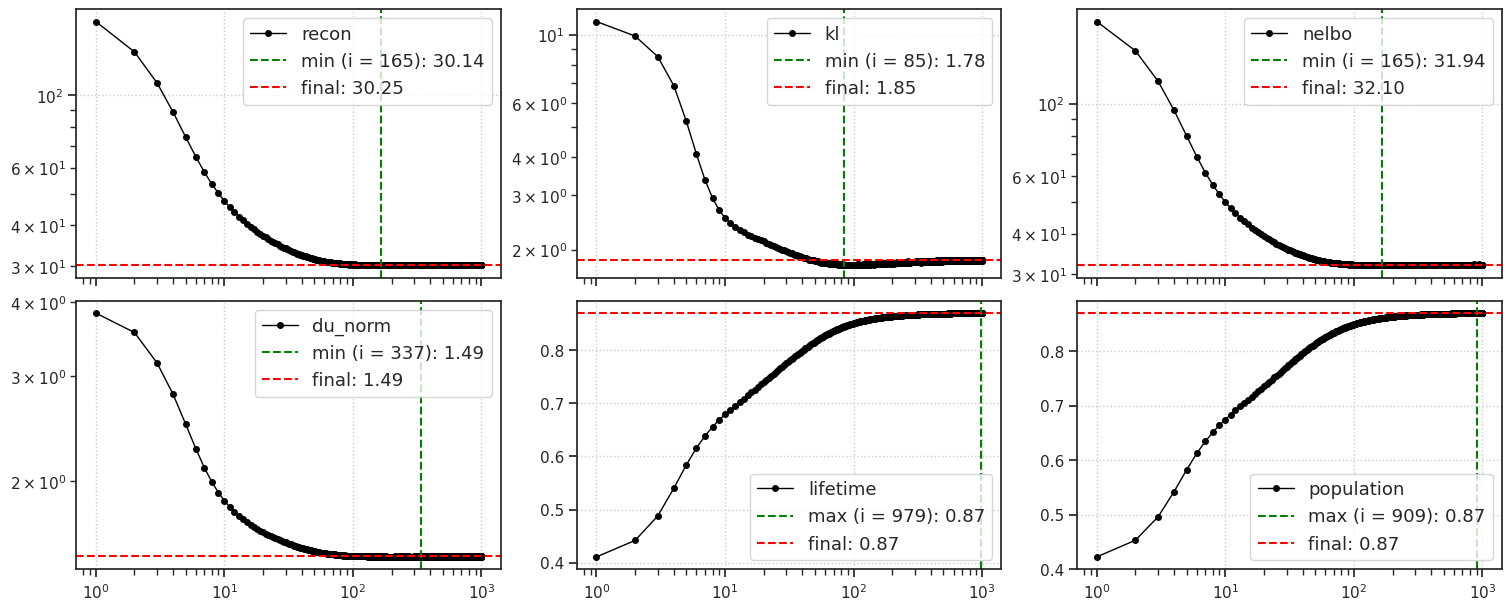

In [15]:
## Was: T = 8  /  beta = 8.0,  clamp_du = 10.0

### Load model

In [3]:
# # adjuster = 'linear'

# # if adjuster is None:
# #     model_name = 'poisson_uniform_c(-4)_vH16_t-8_z-[512]_k-32_<jacob|lin>'
# #     fit_name = 'b500-ep600-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_09_07,13:22)'
# # elif adjuster == 'linear':
# #     model_name = 'poisson_uniform_c(-4)_vH16_t-8_z-[512]_k-32_<jacob|lin>'
# #     fit_name = 'b500-ep600-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_09_07,16:27)'
# # elif adjuster == 'log':
# #     model_name = 'poisson_uniform_c(-4)_vH16_t-8_z-[512]_k-32_<jacob|lin>'
# #     fit_name = 'b500-ep600-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_09_07,13:20)'

# model_name = 'poisson_uniform_c(-2)_CIFAR10_t-8_z-[1024]_k-32_<jacob|conv+b>'
# fit_name = 'b200-ep600-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_08,00:21)'

# tr, meta = load_model(model_name, fit_name, device=device)
# meta['checkpoint']

600

In [11]:
print(tr.cfg.kl_beta, tr.cfg.kl_time_adjuster)

1.0 None

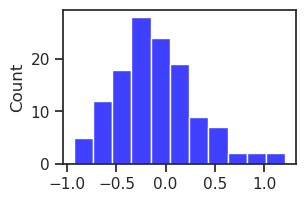

In [12]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

In [13]:
# loc = tonp(tr.model.layer.loc).ravel()
# sns.histplot(loc, color='b');

In [15]:
# dead = loc > 2
# dead.sum()

In [17]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    # active=~dead,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn' , 'tst']
}

100%|█████████████████████████████████| 50/50 [09:37<00:00, 11.54s/it]


CPU times: user 9min 28s, sys: 5.56 s, total: 9min 33s
Wall time: 9min 38s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

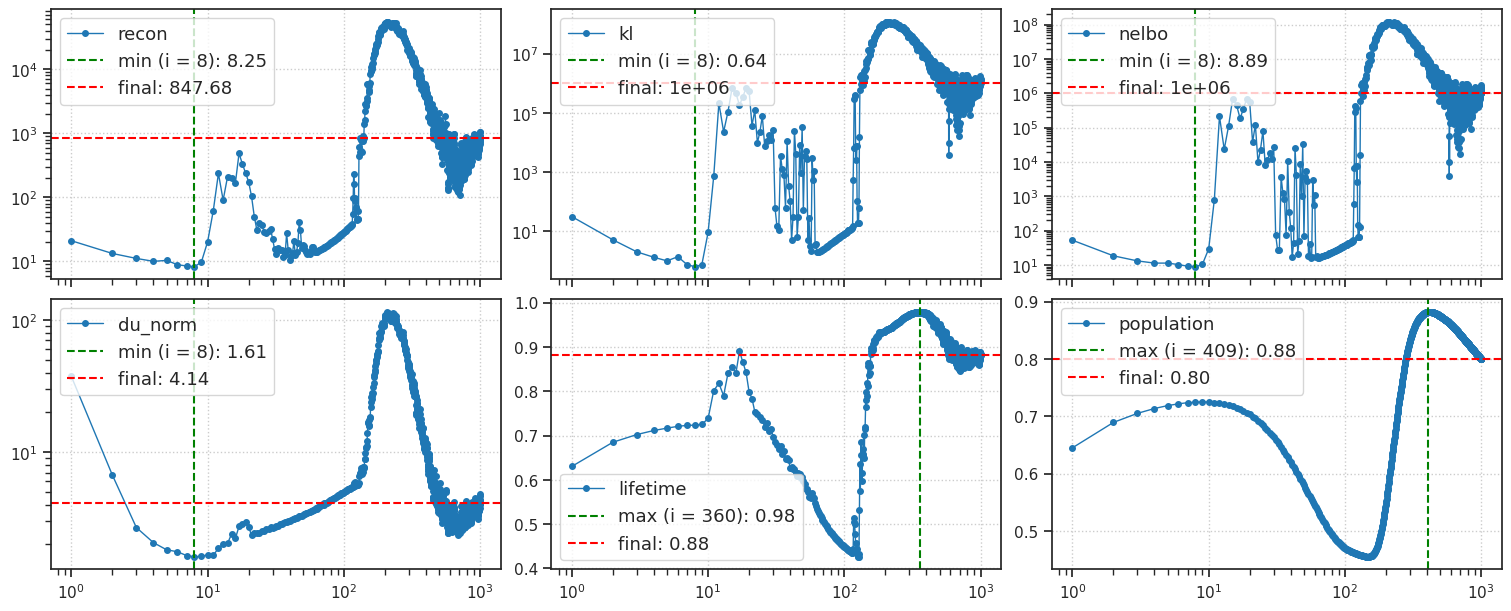

In [18]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [23]:
state = results['vld']['state_final'].copy()
mu, log_sig = state[:, :128], state[:, 128:]

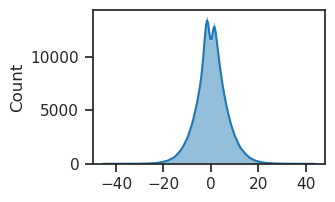

In [40]:
sns.histplot(mu.ravel(), kde=True);

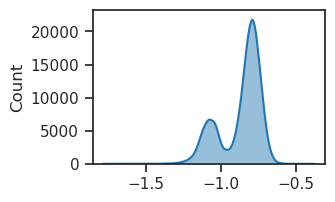

In [41]:
sns.histplot(log_sig.ravel(), kde=True);

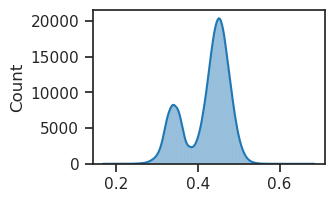

In [42]:
sns.histplot(np.exp(log_sig).ravel(), kde=True);

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

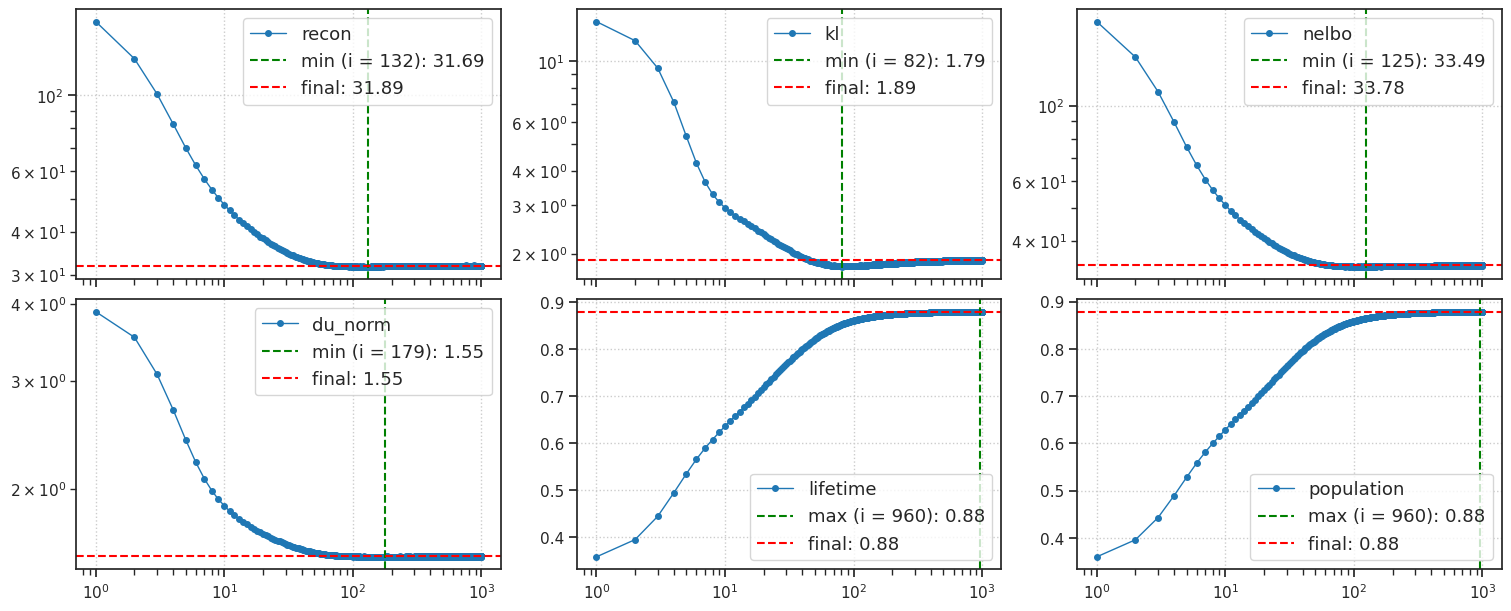

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

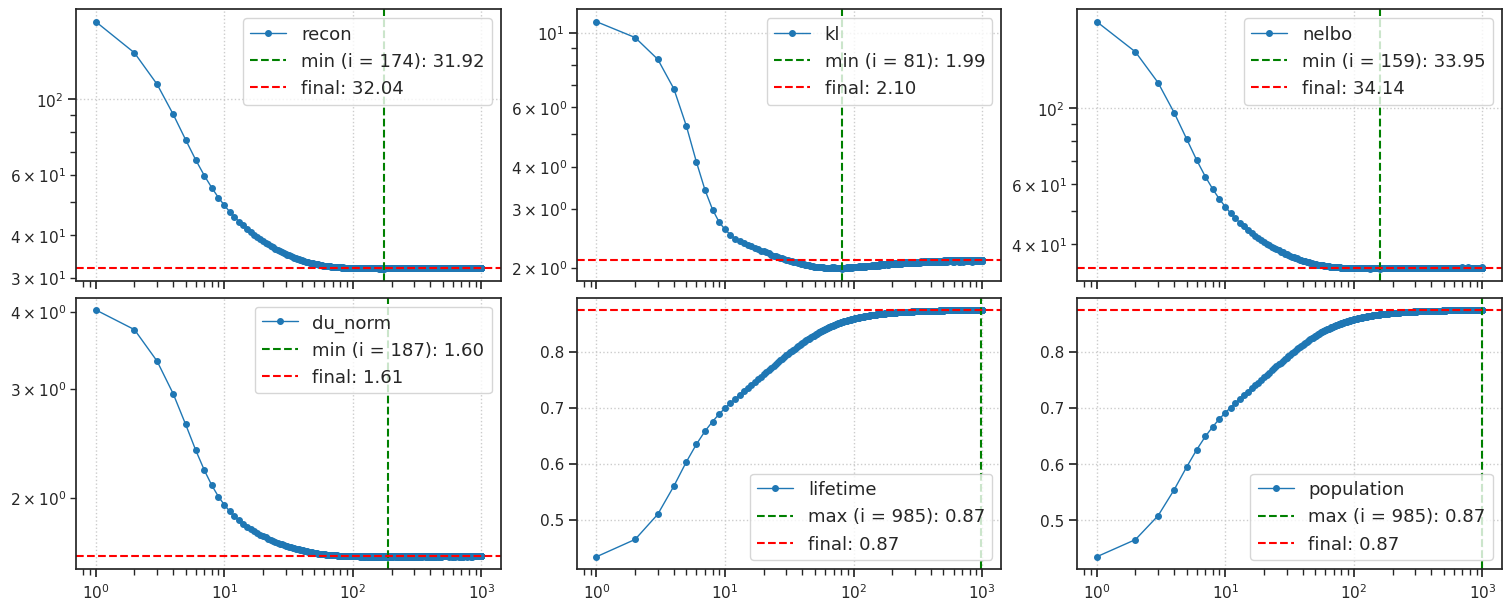

## MNIST

In [10]:
# model_name = 'gaussian_MNIST_t-10_z-[128]_<lin|lin>'
# fit_name = 'mc_b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_06,15:58)'
# tr, meta = load_model(model_name, fit_name, device=device)
# meta['checkpoint']

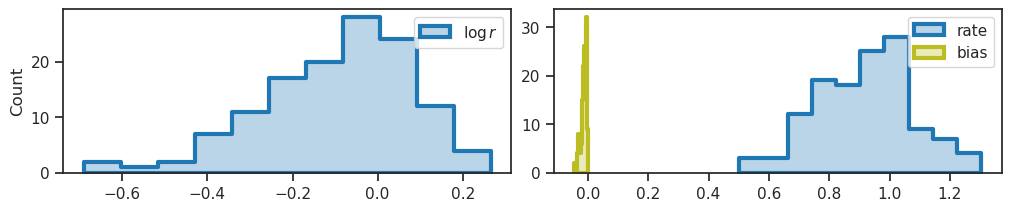

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [15]:
dead = log_rate > 2
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

In [16]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=0,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld', 'trn'] # , 'tst']
}

100%|█████████████████████████████| 300/300 [1:50:05<00:00, 22.02s/it]


CPU times: user 2h 5min 45s, sys: 5min 40s, total: 2h 11min 25s
Wall time: 2h 13min 55s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

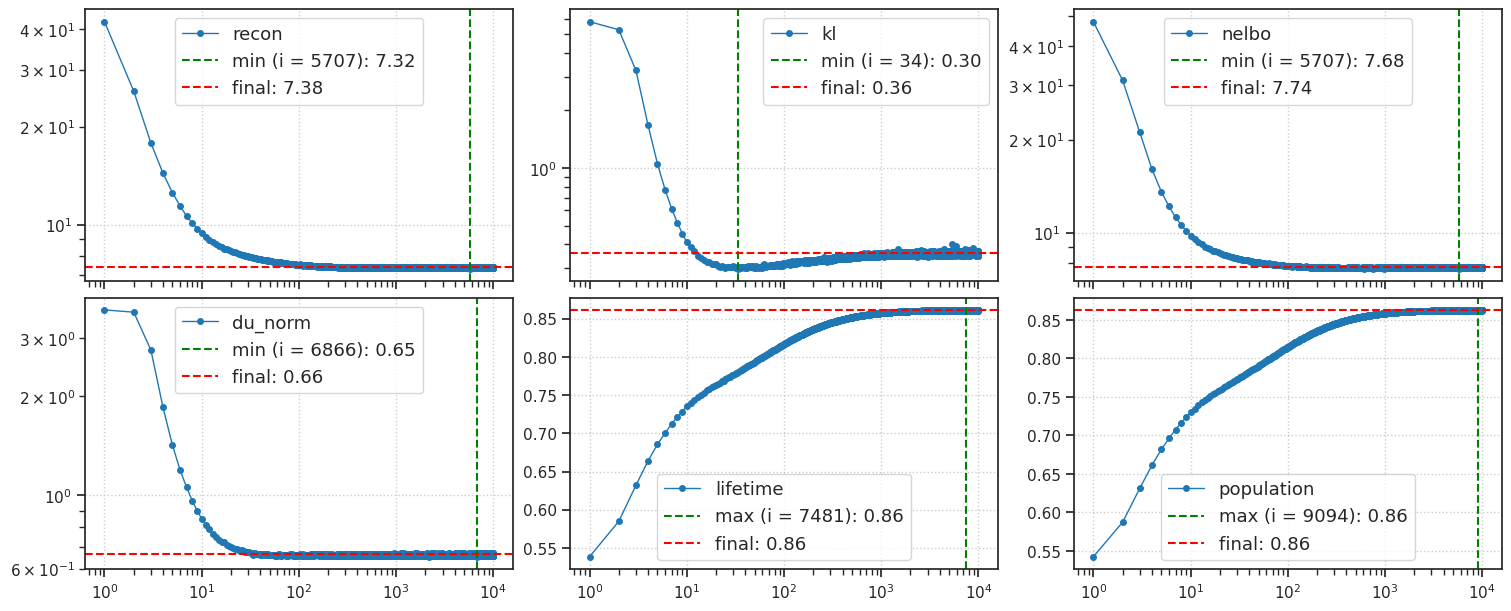

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

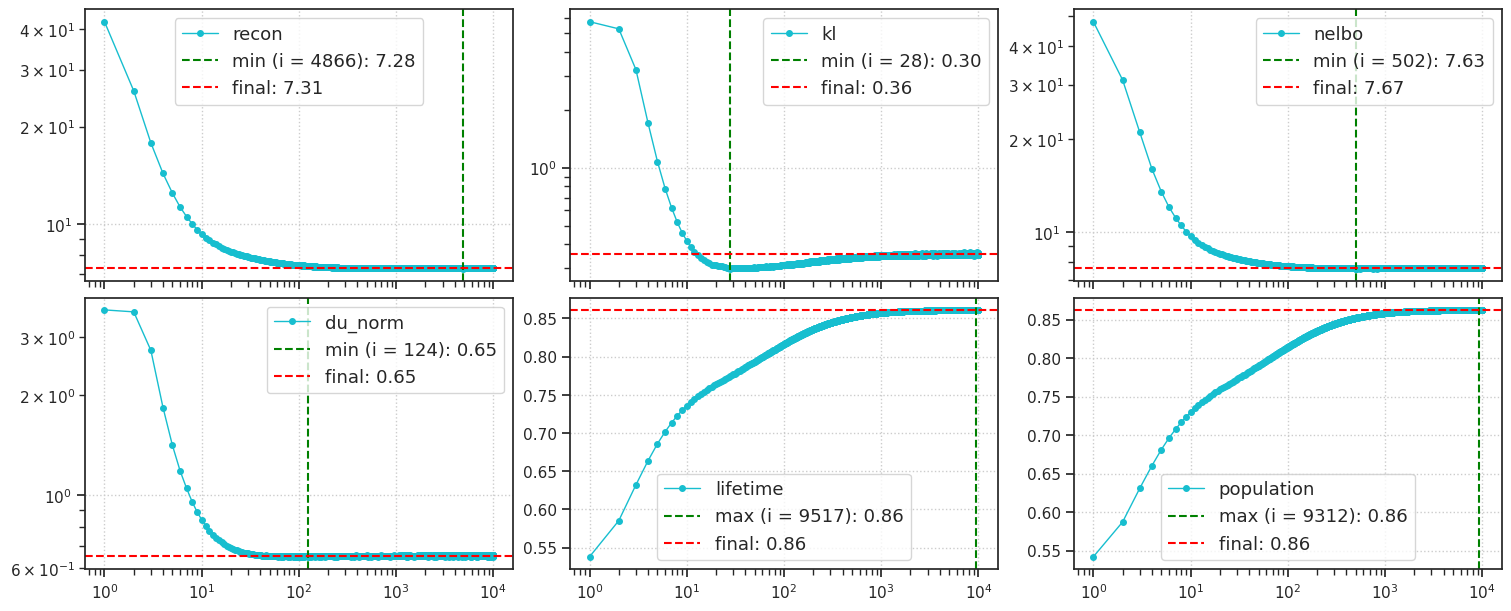

In [17]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

### Generate

In [19]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [22]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

In [23]:
order = np.argsort(desc_len)[::-1]

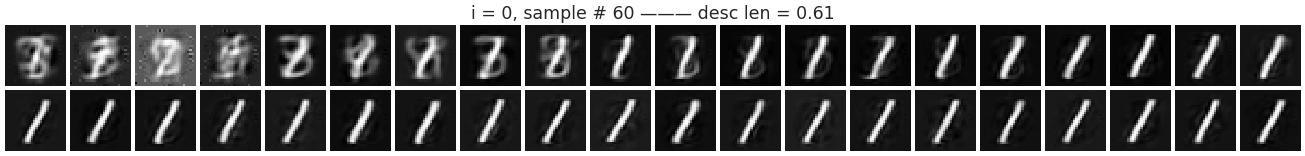

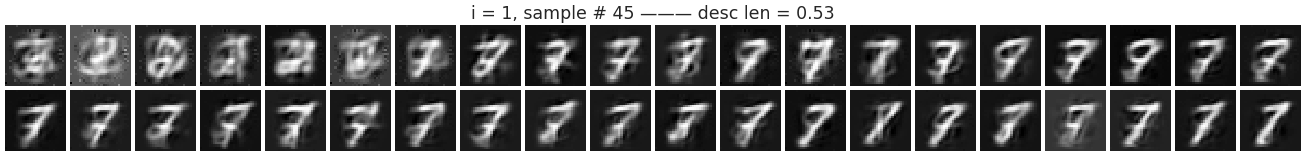

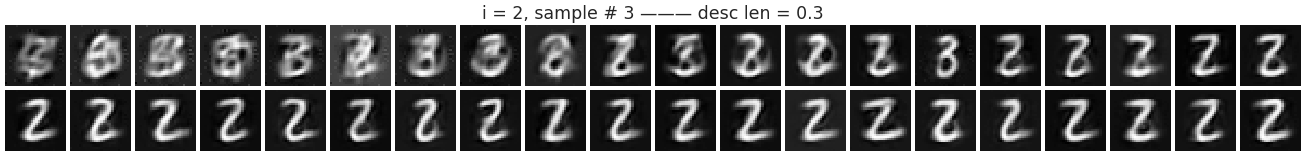

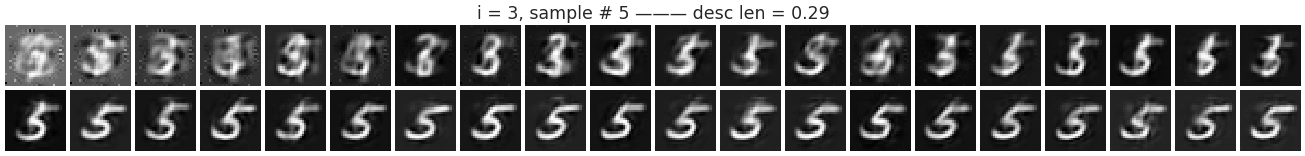

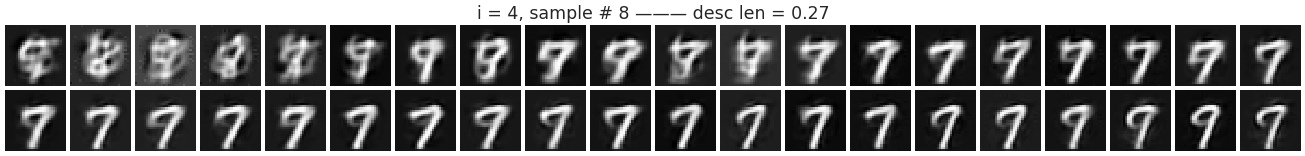

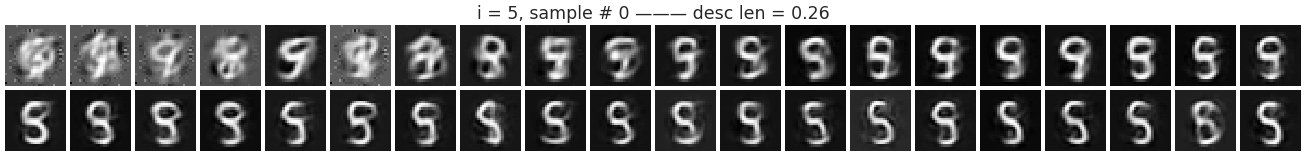

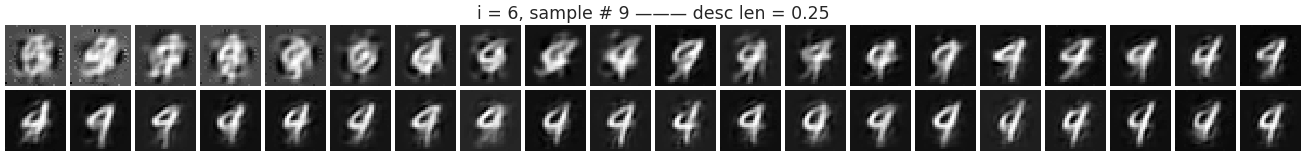

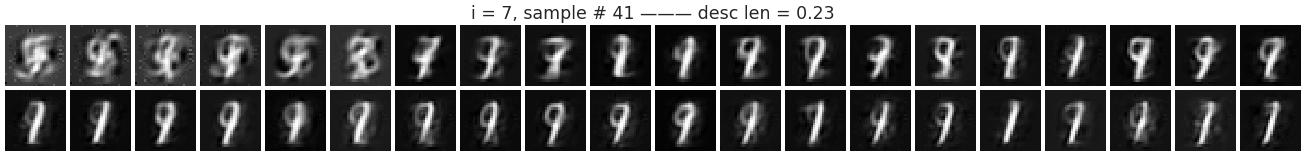

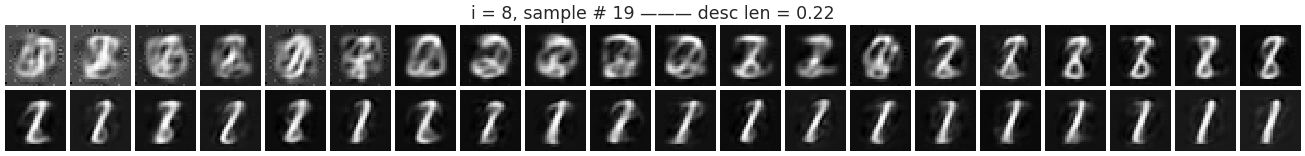

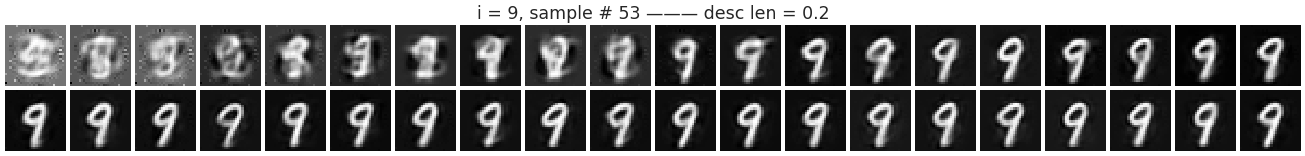

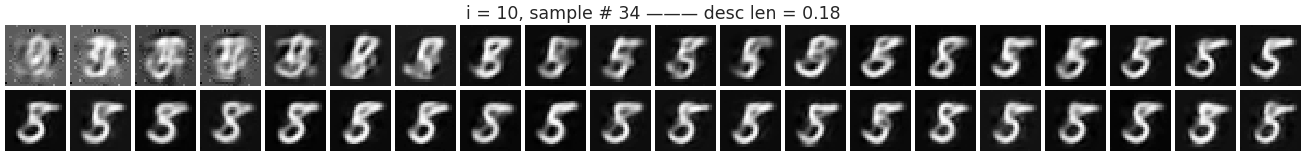

In [24]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()